In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from Functions import PredictiveAnalysis

import dash
from dash import html, dcc, ALL, MATCH, Output, Input, State, no_update, ctx, Patch
import dash_mantine_components as dmc
import dash_bootstrap_components as dbc


In [2]:
# load the clean data frame
df = pd.read_csv('final.csv')
df.head()

,Date,Year,Month,CSENT,IPM,HOUSE,UNEMP,LRIR,SP500,SP500_Price,SP500_Rise
0,1979-01-31,1979,1,-13.859020,7.862464,-5.157233,1.774952,-0.300399,11.966387,99.930000,1.0
1,1979-02-28,1979,2,-12.336892,7.786828,-8.596713,1.774952,-0.671270,10.615806,96.279999,1.0
2,1979-03-31,1979,3,-13.197970,6.418676,-2.579853,1.757858,-1.142366,13.877365,101.589996,1.0
3,1979-04-30,1979,4,-19.117647,2.997984,-13.425926,1.757858,-1.135133,5.091398,101.760002,1.0
4,1979-05-31,1979,5,-17.852835,3.917937,-15.169195,1.722767,-1.637674,1.892230,99.080002,1.0


# Dataset Creation
- Six types of moving averages ; from one to six months.
- Six types of dataset shifts; from one to six months.

In [3]:
"""
class PredictiveAnalysis_Test(PredictiveAnalysis):
    def __init__(self, df):
        super().__init__(df)
"""

'\nclass PredictiveAnalysis_Test(PredictiveAnalysis):\n    def __init__(self, df):\n        super().__init__(df)\n'

In [54]:
PA = PredictiveAnalysis(df)
PA.create_data(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR'], 'SP500', ma=[1,2,3], fp=[1,2,3,4,5,6], poly_d=1)

In [55]:
# check the format of each X and y matrix
print(PA.datasets['1MA_1FP']['X'][:5])
print(PA.datasets['1MA_1FP']['y'][:5])
print(PA.datasets['1MA_1FP']['y_cat'][:5])

[[ 1.         -1.07697478  1.02863002 -0.24524403 -1.08252718 -1.34994328]
 [ 1.         -0.97845534  1.01416757 -0.38013943 -1.08252718 -1.45430278]
 [ 1.         -1.0341884   0.75256061 -0.14415995 -1.17512361 -1.58686461]
 [ 1.         -1.41733832  0.09848356 -0.56953973 -1.17512361 -1.58482934]
 [ 1.         -1.3354736   0.2743895  -0.63791022 -1.36520485 -1.72623957]]
[[10.61580626]
 [13.87736507]
 [ 5.09139751]
 [ 1.89222954]
 [ 7.7253271 ]]
[[1]
 [1]
 [1]
 [1]
 [1]]


# Model Creation & Evaluation

- Four machine learning models
    1. Multiple Linear Regression
    3. Logistic Regression
    4. Classification and Regression Tree

<br>

- Evaluations
    - Regressions:
        - <b>Root Mean Square Error (RMSE)</b>: How much errors could occur between the predicted prices and the actual ones.
        - <b>Standard Error of Estimate (SE)</b>: How much variation could occur in the actual target based on the same condition of independent variables. 
        - <b>Coffeficient of Determination (R2)</b>: How well the regression model explains the variation of a target value.
        - <b>Adjusted R2</b>: R2 with the penalty for the number of independent variables.
        <br><br>
        
    - Classification
        - <b>Accuracy</b>: How the model can correctly predict the target values.
        - <b>Precision</b>: How the model can avoid false positives.
        - <b>Recall</b>: How the model can avoid false negatives.
        - <b>F1 Score</b>: How the model can balance precision and recall.
        - <b>AUC (Area Under the ROC Curve)</b>: How the model can summarize the ROC curve.

### Multiple linear Regression
- Applying different scopes for parameter adjustments; [1,2,3,4,5,6]
- Feature selection by backward elimination for whole models.

In [56]:
# define function to plot vix horizontally

def horizon_plots(figs, model,**subplots_arg):
    perf_figs = make_subplots(rows=1, cols=len(figs), **subplots_arg)
    perf_figs.update_layout(
        height=400, 
        width=300*len(figs) + 50
    )

    annotations = []

    for i, f in enumerate(figs):
        for j, f_d in enumerate(f.data):
            f_d.showlegend = True if i == 0 else False
            perf_figs.add_trace(f_d, row=1, col=i+1)

            if j == 0:
                annotations.append(dict(
                    xref=f'x{i+1}', yref='paper', x=0.5, y=1.05,
                    xanchor='center', yanchor='bottom', text=f.layout.title.text, 
                    font=dict(size=15), showarrow=False
                ))

    perf_figs.update_layout(
        title=f"Comparing the {model} Results on Different Conditions", 
        annotations=annotations, template='plotly_dark',
        legend_title_text='Moving Averages', 
        legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5)
        )
    
    return perf_figs

In [57]:
# comparing model performance & backward elimination test
fig1_1, fig1_2, fig1_3 = PA.model_learning([1, 6, 12, 60], model='LinR')

horizon_plots(fig1_1, 'Linear Model').show()
fig1_2.show()
fig1_3.show()

In [67]:
# detailed performance
fig2_1, fig2_2 = PA.detail_perf(model='LinR', ma=1, fp=6, sc=12)
fig2_1.show()
fig2_2.show()

In [11]:
act_prices_mat = np.zeros((6,6))
future = PA.futures['LinR']
for idx, i in enumerate(future.keys()):
    for j in future[i].keys():
        if j == '1MA':
            #yoy_mean = future[i][j][0]
            yoy_mean = np.mean(future[i][j], axis=0)
            #print("YoY: ", yoy_mean)
            r = 12 - int(i[0])
            act_prices = df['SP500_Price'][-12:-r].values * (yoy_mean/100+1)
            act_prices_mat[idx] = np.pad(act_prices, (0, 6-1-idx), 'constant', constant_values=(0))
            print(act_prices)

np.sum(act_prices_mat, axis=0) / np.count_nonzero(act_prices_mat, axis=0)

[4341.25279528]
[4513.44020321 4116.2792372 ]
[4398.84868786 4196.95247381 4369.36832971]
[4639.59697806 4199.06439235 4476.76236471 4297.67406893]
[4688.86389288 4523.67204262 4534.71884678 4425.41396333 4460.25701111]
[4383.2230617  4334.27705831 4655.71090072 4421.71938853 4491.1383268
 4506.28728883]


array([4494.20426983, 4274.04904086, 4509.14011048, 4381.6024736 ,
       4475.69766895, 4506.28728883])

### Logistic Regression

In [7]:
# comparing model performance & backward elimination test
fig2_1, fig2_2, fig2_3 = PA.model_learning([1, 6, 12, 60], model='LogR')

horizon_plots(fig2_1, 'Logistic Model', shared_yaxes=True).show()
fig2_2.show()
fig2_3.show()

In [17]:
sc_opts = PA.sc_opts
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
figs = fig1_1

In [32]:
app = dash.Dash(__name__)

# Sep up each component
legends = dmc.ChipGroup(
    id={'func': 'compare_perf', 'obj': 'legend'},
    children=[
        dmc.Chip(
            children=str(sc),
            value=str(sc),
            variant="outline", 
            color=colors[i]
            ) for i, sc in enumerate(sc_opts)
    ],
    value=[str(sc) for sc in sc_opts],
    multiple=True,
    style={'display': 'flex', 'justifyContent': 'center'}
)

graphs = html.Div(
    dbc.Row(
        [
            dbc.Col(
                dbc.Card(
                    dbc.CardBody([
                        dcc.Graph(
                            id={'func': 'compare_perf', 'obj': 'fig', 'id': str(i)},
                            figure=fig,
                        )
                    ]),
                    style={'margin': '5px'}
                ),
                width='auto'
            ) for i, fig in enumerate(figs)
        ],
        style={'display': 'flex', 'overflowX': 'auto', 'width': '100%'},
    ),
    style={'maxWidth': '100vw'}
)

@app.callback(
    output=Output({'func': 'compare_perf', 'obj': 'fig', 'id': ALL}, 'figure'),
    inputs=Input({'func': 'compare_perf', 'obj': 'legend'}, 'value'),
    state=State({'func': 'compare_perf', 'obj': 'fig', 'id': ALL}, 'figure')
)
def update_visibility(value, fig):
    # Determine which input was triggered
    triggered_id = ctx.triggered_id
    if triggered_id:
        # define output
        outputs = []
        # get the checked value as set 
        checked = set(value)
        # traversing all figure data
        for f in fig:
            # define patch
            p = Patch()
            for i in range(len(f['data'])):
                p['data'][i].update({'visible': f['data'][i]['name'] in checked})
            
            outputs.append(p)
        
        return outputs
    
    else:
        return no_update


# Set up the Dash app layout 
app.layout = html.Div([
    legends, graphs
])

if __name__ == '__main__':
    app.run_server(debug=False)

html.H3('Comparing the Logistic Regression Model Results on Different Conditions', 
            style={ 'color': 'white'}),
    html.Div(id='fixed-legend', style={'color': 'white'}, children=[
        dcc.Markdown("""
            - Scopes: how many months of the latest data is used for parameter adjustments.
            - Error Bars: Showing mean, min, and max of each measure among various future predictions.
        """)
    ]),

### Memo

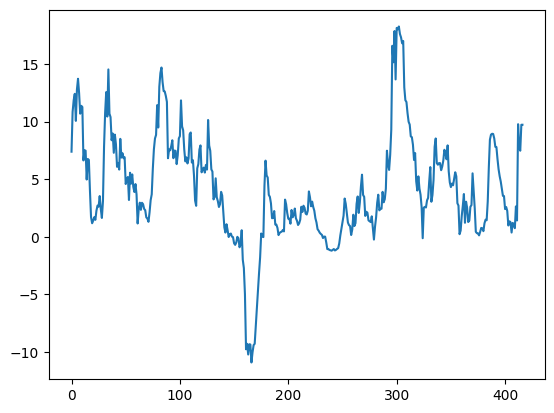

In [24]:
# how the coefficient of the first parameter (CSENT) changed over time
plt.plot(PA.results['LinR']['1FP']['1MA_1SC']['theta'][:, 0])


In [4]:
import dash
from dash import Dash, html, dcc, Input, Output, State, ctx
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [20]:
# Assuming 'sample' is your DataFrame with the data you want to plot
# And it has columns 'X', 'Y1', 'Y2', ... for your data

# Sample data for three dataframes with similar structure
s1 = pd.DataFrame({
    'X': pd.date_range(start='1/1/2020', periods=100),
    'Y1': np.random.randn(100).cumsum(),
    'Y2': np.random.randn(100).cumsum(),
    'Y3': np.random.randn(100).cumsum()
})
s2 = pd.DataFrame({
    'X': pd.date_range(start='1/1/2020', periods=100),
    'Y1': np.random.randn(100).cumsum()*0.5,
    'Y2': np.random.randn(100).cumsum()*0.5,
    'Y3': np.random.randn(100).cumsum()*0.5
})  # Just for example, modify as needed

s3 = pd.DataFrame({
    'X': pd.date_range(start='1/1/2020', periods=100),
    'Y1': np.random.randn(100).cumsum()*2,
    'Y2': np.random.randn(100).cumsum()*2,
    'Y3': np.random.randn(100).cumsum()*2
})   # Just for example, modify as needed


# Define the number of graphs you want to create
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

# Define colors for traces to ensure consistency across subplots
colors = {'Y1': 'blue', 'Y2': 'red', 'Y3': 'green'}

for i, s in enumerate([s1, s2, s3], start=1):
    for col in ['Y1', 'Y2', 'Y3']:
        fig.add_trace(
            go.Scatter(
                x=s['X'],
                y=s[col],
                name=col,
                mode='lines+markers',
                marker=dict(color=colors[col]),
                showlegend=False, # Only the first subplot shows the legend,
                visible=True
            ),
            row=1, col=i
        )

# Update layout to Plotly's dark theme
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font={'color': 'white'},
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    uirevision='constant' # keeps the user-selected legend state consistent across updates
)


app = dash.Dash(__name__)
# Set up the Dash app layout
app.layout = html.Div([
    html.Div(id='custom-legend', children=[
        html.Button('Y1', id='legend-y1', n_clicks=0),
        html.Button('Y2', id='legend-y2', n_clicks=0),
        html.Button('Y3', id='legend-y3', n_clicks=0)
    ], style={'display': 'flex', 'justifyContent': 'center'}),
    html.Div(style={'width': '600px', 'overflowX': 'scroll'}, children=[
        dcc.Graph(id='subplots-graph', figure=fig, style={'width': '1500px'})
    ])
])


@app.callback(
    output=Output('subplots-graph', 'figure'),
    inputs=dict(
        data=dict(
            y1=Input('legend-y1', 'n_clicks'),
            y2=Input('legend-y2', 'n_clicks'),
            y3=Input('legend-y3', 'n_clicks'),
        ),
    ),
    state=dict(fig=State('subplots-graph', 'figure'))
)
def update_graph_visibility(data, fig):
    # Determine which input was triggered
    triggered_id = ctx.triggered_id

    if triggered_id in {'legend-y1', 'legend-y2', 'legend-y3'}:
        # Get series name (e.g., 'Y1', 'Y2', 'Y3')
        series_name = triggered_id.split('-')[-1]
        # Toggle visibility
        visibility = False if data[series_name] % 2 == 1 else True
    
        # Update traces
        for trace in fig['data']:
            if trace['name'].lower() == series_name:
                trace['visible'] = visibility

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)
